# Retrieve and visualize sweep results
In our setup, each job computes an embedding for a given method and parameter combination in isolation and send the results to wandb. There are plently of ways to visualize the results on the wandb dashbord, for example parallel coordinate plots, which help to understand paramter importance. 

However, the scIB results on wandb don't have the usual min-max column scaling that's frequently used in plots, because such scaling requires all results to be available at once, while each of our jobs only has access to a single run. Here we'll aggregate sweep results from wandb and visualize them jointly with the usual min-max column scaling. 

## Preliminaries

### Library imports

`autoreload` to re-load packages. 

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The actual imports. 

In [32]:
import warnings

import matplotlib.pyplot as plt
import rapids_singlecell as rsc
import scanpy as sc
import scvi
from scembed import scIBAggregator
from scembed.utils import load_embedding

### Load data

To visualze UMAPs later on, we need to original dataset

In [3]:
adata = sc.read("data/lung_atlas.h5ad", backup_url="https://figshare.com/ndownloader/files/24539942")
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

### Preprocessing

To load pre-computed models below, we need to subset the AnnData object to the same number of features as during training. 

In [4]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key="batch", subset=True)

## Main

### Fetch runs from weights and biases (wandb)

Specify the details of your project first. 

In [5]:
agg = scIBAggregator(entity="spatial_vi", project="scembed_test_3", output_dir="top_results")
agg

INFO     Initialized scIBAggregator for spatial_vi/scembed_test_3                                                  


scIBAggregator(spatial_vi/scembed_test_3, no data fetched)

Now, fetch all runs for this project, across all sweeps. 

In [6]:
agg.fetch_runs()

INFO     Fetching runs from spatial_vi/scembed_test_3...                                                           


Processing runs: 100%|██████████| 25/25 [00:00<00:00, 9561.19it/s]

INFO     Fetched 25 runs                                                                                           
INFO     Available scIB metrics: ['BRAS', 'Graph connectivity', 'Isolated labels', 'KBET', 'KMeans ARI', 'KMeans   
         NMI', 'PCR comparison', 'Silhouette label', 'cLISI', 'iLISI']                                             
INFO     Processing complete: 7 methods, 0 runs filtered out                                                       


We can now print the object again to get some more info. 

In [7]:
print(agg)

scIBAggregator(spatial_vi/scembed_test_3, 25/25 runs, 7 methods, 10 metrics, output_dir='top_results')


### Inspect individual method

First, let's look at an individual method to understand how different parameters influence performance. Method data is stored in `agg.method_data`: 

In [8]:
agg.method_data.keys()

dict_keys(['harmony', 'scpoli', 'scvi', 'scanorama', 'liger', 'scanvi', 'precomputed_pca'])

Let's take a look at this for `harmony`. 

In [9]:
agg.method_data["harmony"].keys()

dict_keys(['configs', 'scib_benchmarker', 'other_logs'])

The `scib_benchmarker` object can be used just like the regular scIB output: 

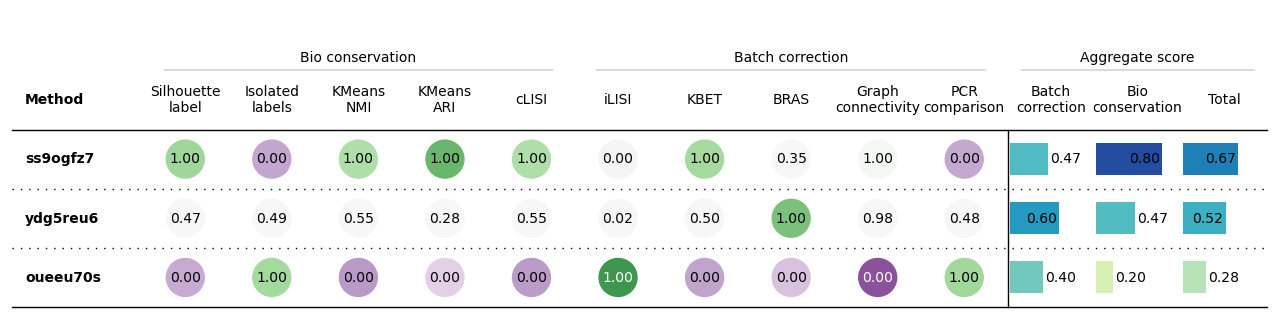

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    agg.method_data["harmony"]["scib_benchmarker"].plot_results_table(min_max_scale=True)

The differences aren't hughe, but we can still take a look at the corresponding configs. 

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    res = agg.get_method_runs("harmony")["configs"]

res

,theta,method
Embedding,,
ss9ogfz7,1,harmony
ydg5reu6,2,harmony
oueeu70s,5,harmony


It looks like `theta=1` works best in this case. 

### Aggregate results across methods

The main thing we want to get out if of course which method workes best on this dataset. For this, we call `.aggregate`, which selects the best performing run per method. 

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    agg.aggregate()

INFO     Aggregated best runs for 7 methods using metric 'Total'                                                   


Now, there's a `.results` attribute that looks just like the methods above:

In [21]:
agg.results.keys()

dict_keys(['configs', 'scib_benchmarker', 'other_logs'])

Again, the `scib_bencharker` be be used like regular scIB output. 

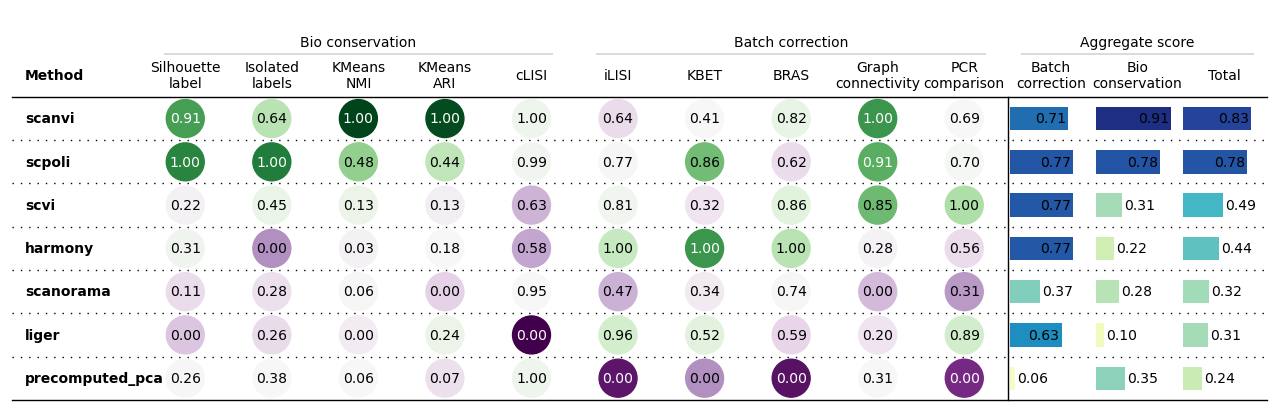

In [22]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    agg.results["scib_benchmarker"].plot_results_table(min_max_scale=True)

It looks like we have a clear winner here. Again, we can take a look at the corresponding config for each of these best performing runs. 

In [23]:
agg.results["configs"]

,run_id,theta,n_epochs,embedding_dims,pretraining_epochs,n_latent,n_layers,alpha,sigma,k,value_lambda,scvi_params,early_stopping,n_sample_per_label,embedding_key
harmony,ss9ogfz7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scpoli,1l6wz4zn,NaN,50.0,10.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scvi,dalpawjk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scanorama,94gwaro9,NaN,NaN,NaN,NaN,NaN,NaN,0.1,15.0,NaN,NaN,NaN,NaN,NaN,NaN
liger,hdjpulqs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,1.0,NaN,NaN,NaN,NaN
scanvi,55ek95q5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'n_latent': 10, 'n_layers': 2, 'max_epochs': ...",NaN,NaN,NaN
precomputed_pca,swvv6ets,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X_pca


We can also just get the aggregated results dataframe. 

In [24]:
agg.results["scib_benchmarker"].get_results()

,Silhouette label,Isolated labels,KMeans NMI,KMeans ARI,cLISI,iLISI,KBET,BRAS,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,,
harmony,0.592363,0.535524,0.67637,0.506747,0.996828,0.130154,0.483724,0.777517,0.757674,0.444529,0.518719,0.661567,0.604428
scpoli,0.69086,0.865071,0.757564,0.576861,0.99991,0.101976,0.448438,0.655431,0.947758,0.556567,0.542034,0.778053,0.683646
scvi,0.580029,0.682542,0.694103,0.494832,0.997192,0.106475,0.306105,0.732668,0.929597,0.798901,0.574749,0.68974,0.643743
scanorama,0.563862,0.626689,0.682006,0.45905,0.999589,0.065544,0.312594,0.69479,0.672073,0.245228,0.398046,0.666239,0.558962
liger,0.548596,0.619629,0.670398,0.523743,0.992377,0.12526,0.359391,0.646403,0.732332,0.707661,0.514209,0.670949,0.608253
scanvi,0.677761,0.745937,0.853682,0.728752,1.0,0.085841,0.329241,0.719637,0.975216,0.547914,0.53157,0.801226,0.693364
precomputed_pca,0.585415,0.661278,0.682006,0.476682,1.0,0.008071,0.223213,0.460335,0.764946,0.0,0.291313,0.681076,0.525171
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


### Retrieve embeddings

For each best-performing model, let's download the model weights (if available) and the embedding to a local folder. 

In [25]:
agg.get_models_and_embeddings()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  


INFO     Downloaded embeddings for method 'harmony' to top_results/harmony/                                        
WARNING  Missing model for method 'harmony' (run_id: ss9ogfz7)                                                     


wandb:   3 of 3 files downloaded.  
wandb:   1 of 1 files downloaded.  


INFO     Downloaded models and embeddings for method 'scpoli' to top_results/scpoli/                               


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


INFO     Downloaded models and embeddings for method 'scvi' to top_results/scvi/                                   


wandb:   1 of 1 files downloaded.  


INFO     Downloaded embeddings for method 'scanorama' to top_results/scanorama/                                    
WARNING  Missing model for method 'scanorama' (run_id: 94gwaro9)                                                   


wandb:   1 of 1 files downloaded.  


INFO     Downloaded embeddings for method 'liger' to top_results/liger/                                            
WARNING  Missing model for method 'liger' (run_id: hdjpulqs)                                                       


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


INFO     Downloaded models and embeddings for method 'scanvi' to top_results/scanvi/                               


wandb:   1 of 1 files downloaded.  


INFO     Downloaded embeddings for method 'precomputed_pca' to top_results/precomputed_pca/                        
WARNING  Missing model for method 'precomputed_pca' (run_id: swvv6ets)                                             


Now, we can simply load some of these embeddings, compute UMAPs, and visualize.

In [26]:
keys = ["scanvi", "scpoli", "precomputed_pca"]

for key in keys:
    adata.obsm[f"X_{key}"] = load_embedding(f"top_results/{key}/embeddings/embedding.parquet")
    adata.obsm[f"X_{key}"] = adata.obsm[f"X_{key}"].values

    rsc.pp.neighbors(adata, use_rep=f"X_{key}")
    rsc.tl.umap(adata, key_added=f"umap_{key}")

Now, let's take a look at these. 

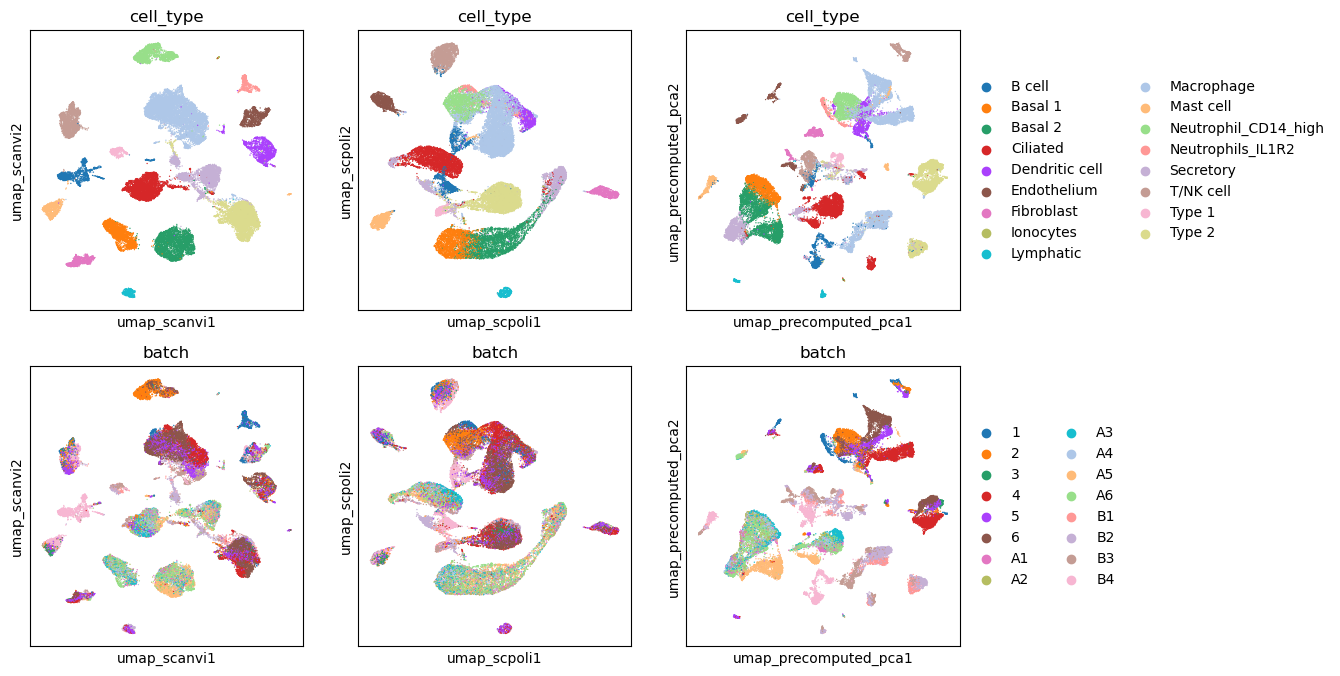

In [27]:
fix, axes = plt.subplots(2, len(keys), figsize=(4 * len(keys), 8))


for i, key in enumerate(keys):
    shared_params = {
        "basis": f"umap_{key}",
        "show": False,
        "legend_loc": "right margin" if i == len(keys) - 1 else "none",
    }
    sc.pl.embedding(adata, color="cell_type", ax=axes[0, i], **shared_params)
    sc.pl.embedding(adata, color="batch", ax=axes[1, i], **shared_params)

plt.show()

### Retrieve models

Above, we also downloaded the models, so we can easily import one of them here. 

In [28]:
model_key = "scvi"
model = scvi.model.SCVI.load(f"top_results/{model_key}/models", adata=adata)

INFO     File top_results/scvi/models/model.pt already downloaded                                                  


/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cluster/project/treutlein/USERS/mlange/miniforge3/e ...
/cluster/project/treutlein/USERS/mlange/github/scvi-tools/src/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


Given the model, we can for example retireve the embedding coordinates, and visualize again with UMAP. 

In [29]:
adata.obsm[f"X_{model_key}"] = model.get_latent_representation()

rsc.pp.neighbors(adata, use_rep=f"X_{model_key}")
rsc.tl.umap(adata, key_added=f"umap_{model_key}")

We can now include this embedding with the others from above and plot again. 

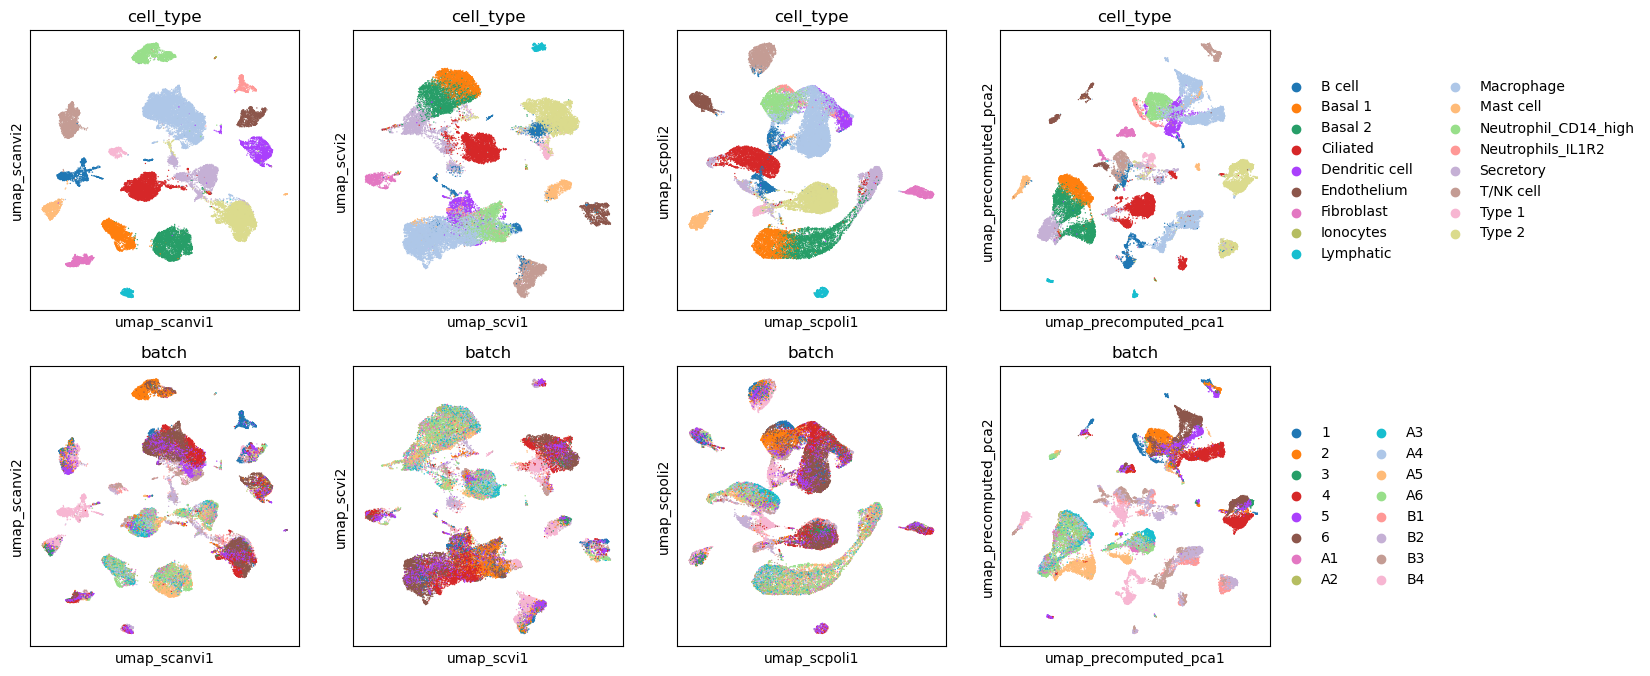

In [30]:
keys = ["scanvi", "scvi", "scpoli", "precomputed_pca"]
fix, axes = plt.subplots(2, len(keys), figsize=(4 * len(keys), 8))

for i, key in enumerate(keys):
    shared_params = {
        "basis": f"umap_{key}",
        "show": False,
        "legend_loc": "right margin" if i == len(keys) - 1 else "none",
    }
    sc.pl.embedding(adata, color="cell_type", ax=axes[0, i], **shared_params)
    sc.pl.embedding(adata, color="batch", ax=axes[1, i], **shared_params)

plt.show()

Of course, we could have also imported the scVI embedding directoy, but importing the model gives us more flexibility. For example, we could use the model to do differential expression testing, or for label-based models like scANVI, we could use it for classification. 